In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from lib import load_data
import seaborn as sns
%matplotlib inline

In [4]:
users_df, costs_df, relations_df, visits_df, orders_df = load_data()

### Задание №2:
### 1. Рассчитать для показателей Retention (процент вернувшихся пользователей на сайт) целевые lifetimes в разрезе маркетинговых источников.

In [5]:
print('Users registrations slice: {} -- {}'.format(
    users_df['Reg_date'].max().strftime('%Y-%m-%d'), 
    users_df['Reg_date'].min().strftime('%Y-%m-%d')))

Users registrations slice: 2017-12-31 -- 2017-06-01


#### Limit lifetimes to 30 days

In [6]:
lifetime_days_limit = 30
mask = users_df['Reg_date'] < (users_df['Reg_date'] - np.timedelta64(lifetime_days_limit, 'D'))
users_df.drop(users_df.index[mask], inplace=True)

#### Join the tables

In [7]:
users_df = users_df.merge(relations_df, how='inner', on=['name', 'id_partner'])

In [8]:
visits_df = visits_df.merge(users_df[['Reg_date','chanel','id']], 
                            how='right', left_on='id_user', right_on='id')

#### Find how many days passed till visit since registration

In [9]:
visits_df['Visit_date'] = visits_df['Visit_date'].dt.normalize()

In [10]:
no_visits_mask = visits_df['Visit_date'].isnull()
visits_df.loc[no_visits_mask, 'Visit_date'] = visits_df.loc[no_visits_mask, 'Reg_date']

In [11]:
visits_df['day'] = visits_df['Visit_date'] - visits_df['Reg_date']

#### Drop some strange visits before registration date

In [12]:
mask = (visits_df['day'] < np.timedelta64(0, 'D'))
visits_df.drop(visits_df.index[mask], inplace=True)

In [13]:
grouped = visits_df.groupby(['chanel', 'day'])

lifetimes = grouped.agg({'id': pd.Series.nunique})
lifetimes.rename(columns={'id': 'num_users'}, inplace=True)

In [14]:
chanel_user_num = lifetimes['num_users'].groupby(level=0).first()

#### Limit to chanels with more than 10 registered users

In [23]:
chanels_with_few_users = chanel_user_num.index[chanel_user_num < 10]

In [24]:
user_retention = 100 * lifetimes['num_users'].unstack(0).divide(chanel_user_num, axis=1)
user_retention_slice = user_retention[:lifetime_days_limit+1][user_retention.columns[~user_retention.columns.isin(chanels_with_few_users)]]

In [25]:
user_retention_slice.fillna(0, inplace=True)

In [26]:
user_retention_slice.set_index(pd.Series(user_retention_slice.index).dt.days, inplace=True)

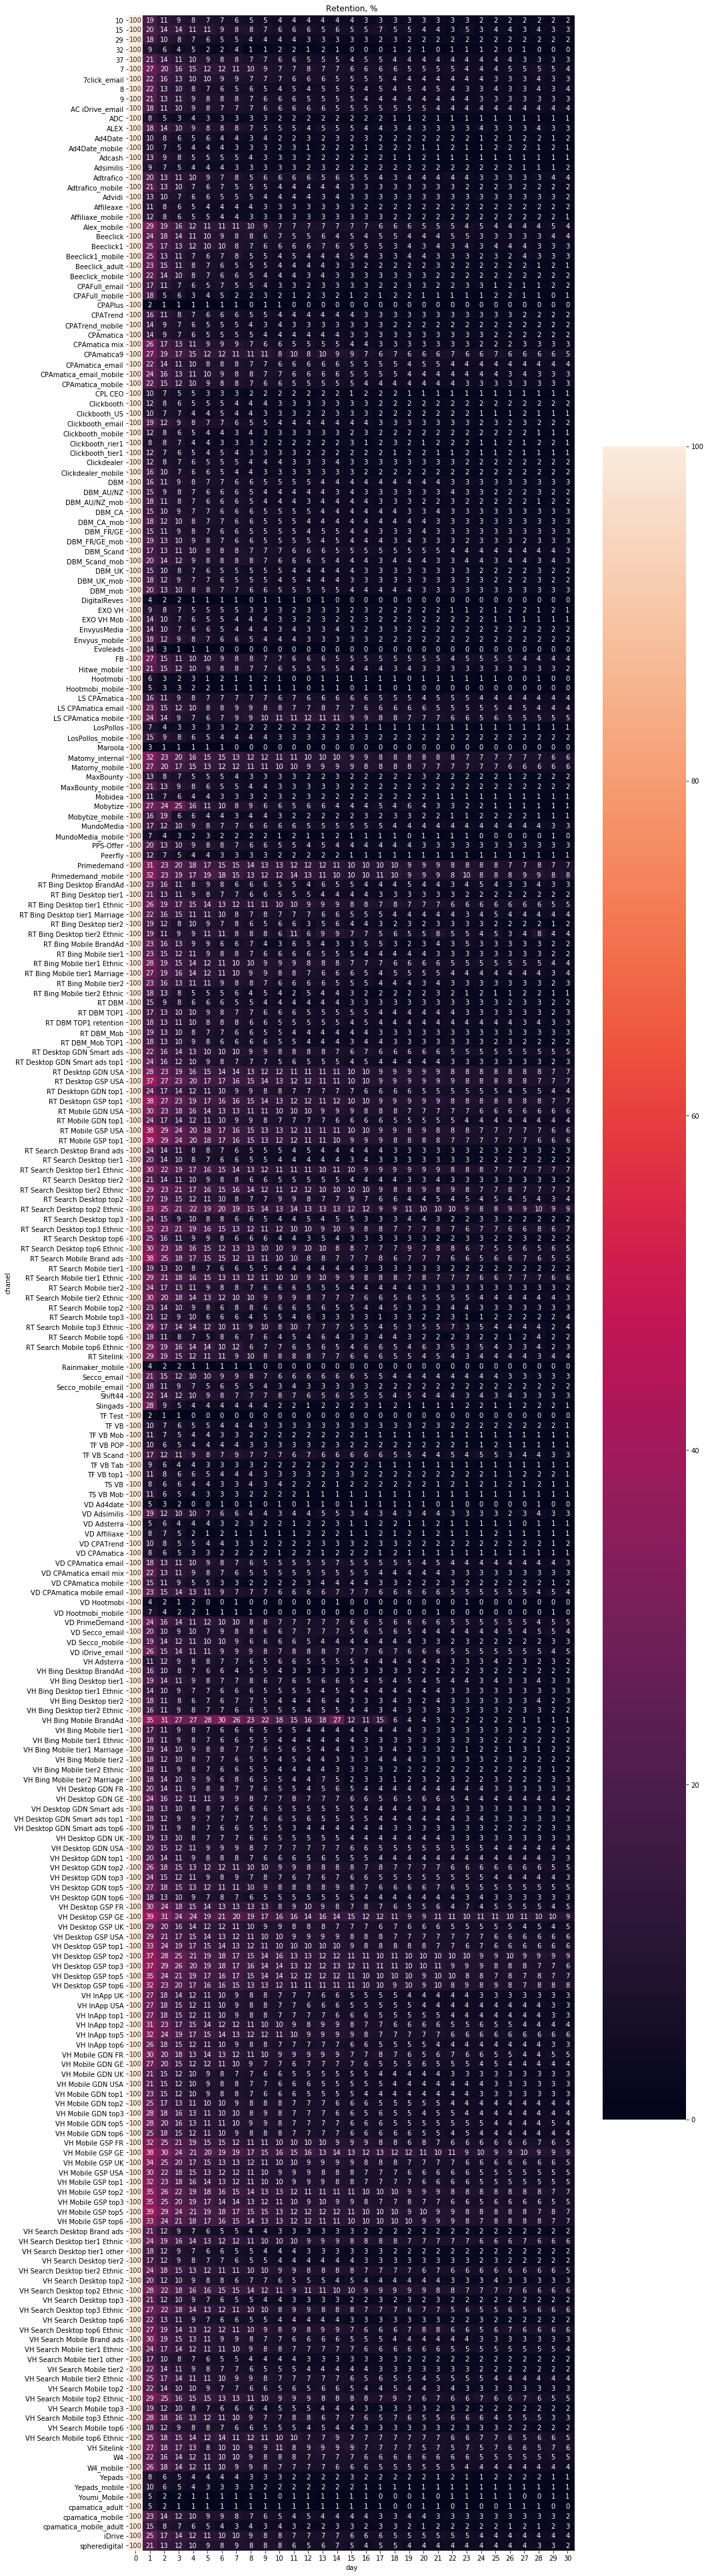

In [27]:
sns.set(style='white')
plt.figure(figsize=(15, 70))
plt.title('Retention by channels during users\' lifetime, %')
ax = sns.heatmap(user_retention_slice.T, annot=True, fmt='.0f');
ax = ax.set(xlabel='day', ylabel='chanel')
plt.show()

In [ ]:
# pd.to_datetime(user_retention_slice.index.values).dt.date
# pd.to_datetime(df['Timestamp'], format = '%Y%m%d_%H%M%S.%f')

### 2. Рассчитать для показателей Revenue (выручка) целевые lifetimes в разрезе маркетинговых источников.

In [81]:
orders_df = orders_df.merge(users_df[['Reg_date','chanel','id']], 
                            how='right', left_on='id_user', right_on='id')

In [82]:
orders_df['Reg_date']

0         2017-06-01
1         2017-06-01
2         2017-06-01
3         2017-06-01
4         2017-06-01
5         2017-06-01
6         2017-06-01
7         2017-06-01
8         2017-06-01
9         2017-06-01
10        2017-06-01
11        2017-06-01
12        2017-06-01
13        2017-06-01
14        2017-06-01
15        2017-06-01
16        2017-06-01
17        2017-06-01
18        2017-06-01
19        2017-06-01
20        2017-06-01
21        2017-06-01
22        2017-06-01
23        2017-06-01
24        2017-06-01
25        2017-06-01
26        2017-06-01
27        2017-06-01
28        2017-06-01
29        2017-06-01
             ...    
2670578   2017-06-22
2670579   2017-06-30
2670580   2017-07-03
2670581   2017-07-04
2670582   2017-07-10
2670583   2017-08-07
2670584   2017-09-12
2670585   2017-09-15
2670586   2017-09-19
2670587   2017-10-27
2670588   2017-10-30
2670589   2017-12-21
2670590   2017-09-05
2670591   2017-09-05
2670592   2017-09-05
2670593   2017-09-05
2670594   201

In [83]:
no_orders = orders_df['Amount'].isnull()
orders_df['Order Date'] = orders_df['Order Date'].dt.normalize()
orders_df.loc[no_orders, 'Amount'] = 0
orders_df.loc[no_orders, 'Order Date'] = orders_df.loc[no_orders, 'Reg_date']
orders_df['day'] = orders_df['Order Date'] - orders_df['Reg_date']

In [84]:
grouped = orders_df.groupby(['chanel', 'day'])
lifetimes = grouped.agg({'Amount': 'sum'})

In [121]:
chanel_revenue = lifetimes.groupby(level=0).sum()
hundred_thousand_revenue_chanels = chanel_revenue.index[chanel_revenue['Amount'] >= 100000]
minor_revenue_chanels = chanel_revenue.index[(chanel_revenue['Amount'] < 100000) & (chanel_revenue['Amount'] > 0)]
zero_revenue_chanels = chanel_revenue.index[chanel_revenue['Amount'] == 0]
print('Chanels without revenues: {}'.format(zero_revenue_chanels.values))

Chanels without revenues: ['14' '305' '309' '32' '34' '48' '52' 'AC Matomy_internal' 'Ad4date'
 'Ad4date_mobile' 'Advidi_email' 'AsiaCharm' 'CPAFull_mobile' 'CPAPlus'
 'CPAmatica_mix' 'DBM VB' 'DigitalRaves' 'DigitalReves' 'EXO AUNZ_Mob'
 'EXO VH AU / NZ' 'EXO VH CA_Mob' 'EXO VH Canada' 'EXO VH UK'
 'EXO VH UK_Mob' 'Evoleads' 'Ilya Alex' 'LS Clickbooth email'
 'LS Evolution' 'LS Evolution email' 'MDSP VB' 'Maroola_email'
 'MaxBounty_email' 'RT Bing' 'RT Bing Desktop FR'
 'RT Bing Desktop FR Ethnic' 'RT Bing Desktop tier2 Marriage'
 'RT Bing Desktop top2' 'RT Bing Desktop top2 Ethnic'
 'RT Bing Desktop top3 Ethnic' 'RT Bing Desktop top6'
 'RT Bing Desktop top6 Ethnic' 'RT Bing Mobile tier2 Marriage'
 'RT Bing Mobile top2' 'RT Bing Mobile top2 Ethnic'
 'RT Bing Mobile top3 Ethnic' 'RT Bing desktop top2 Ethnic'
 'RT Search Mobile top3' 'RT Search Mobile top6' 'RT Serarch Desktop FR'
 'RT Serarch Desktop tier2' 'RT Serarch Desktop top2'
 'RT Serarch Desktop top6' 'RT Serarch Mobile FR' 'RT

In [122]:
revenue_lifetimes = lifetimes['Amount'].unstack(0)
revenue_lifetimes.fillna(0, inplace=True)

In [123]:
revenue_lifetimes_slice = revenue_lifetimes[:lifetime_days_limit+1][hundred_thousand_revenue_chanels]
revenue_lifetimes_slice.set_index(pd.Series(revenue_lifetimes_slice.index).dt.days, inplace=True)

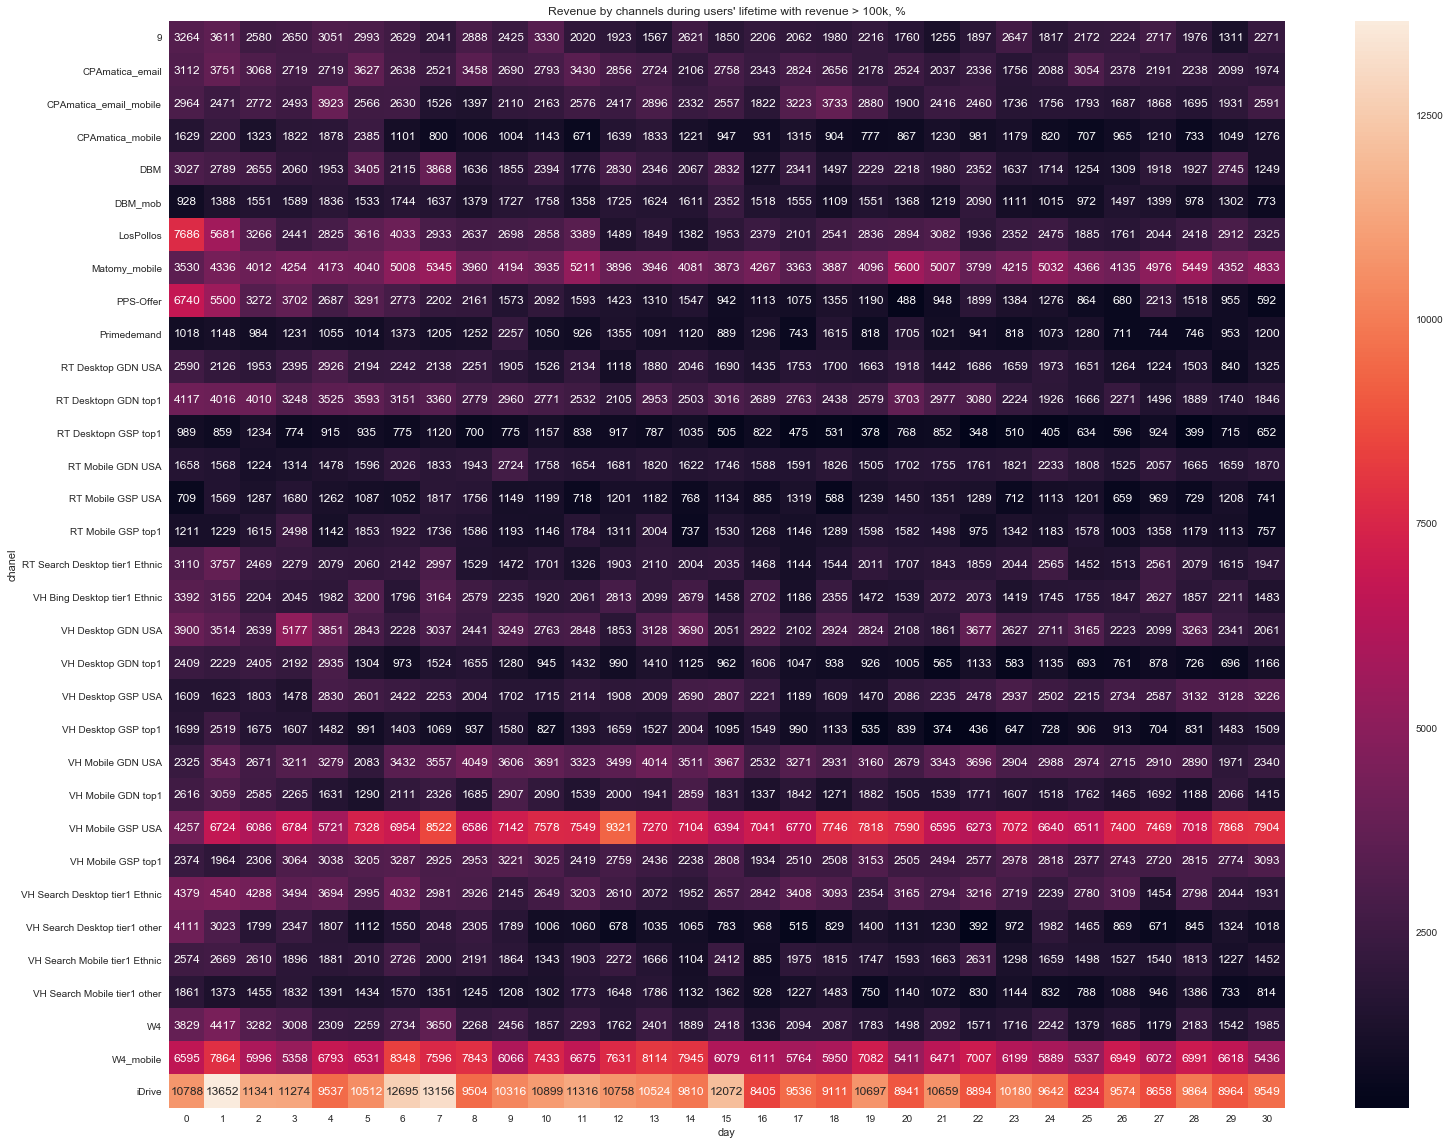

In [119]:
sns.set(style='white')
plt.figure(figsize=(25, 20))
plt.title('Revenue by channels during users\' lifetime with revenue > 100k, %')
ax = sns.heatmap(revenue_lifetimes_slice.T, annot=True, fmt='.0f');
ax = ax.set(xlabel='day', ylabel='chanel')
plt.show()

In [124]:
revenue_lifetimes_slice = revenue_lifetimes[:lifetime_days_limit+1][minor_revenue_chanels]
revenue_lifetimes_slice.set_index(pd.Series(revenue_lifetimes_slice.index).dt.days, inplace=True)

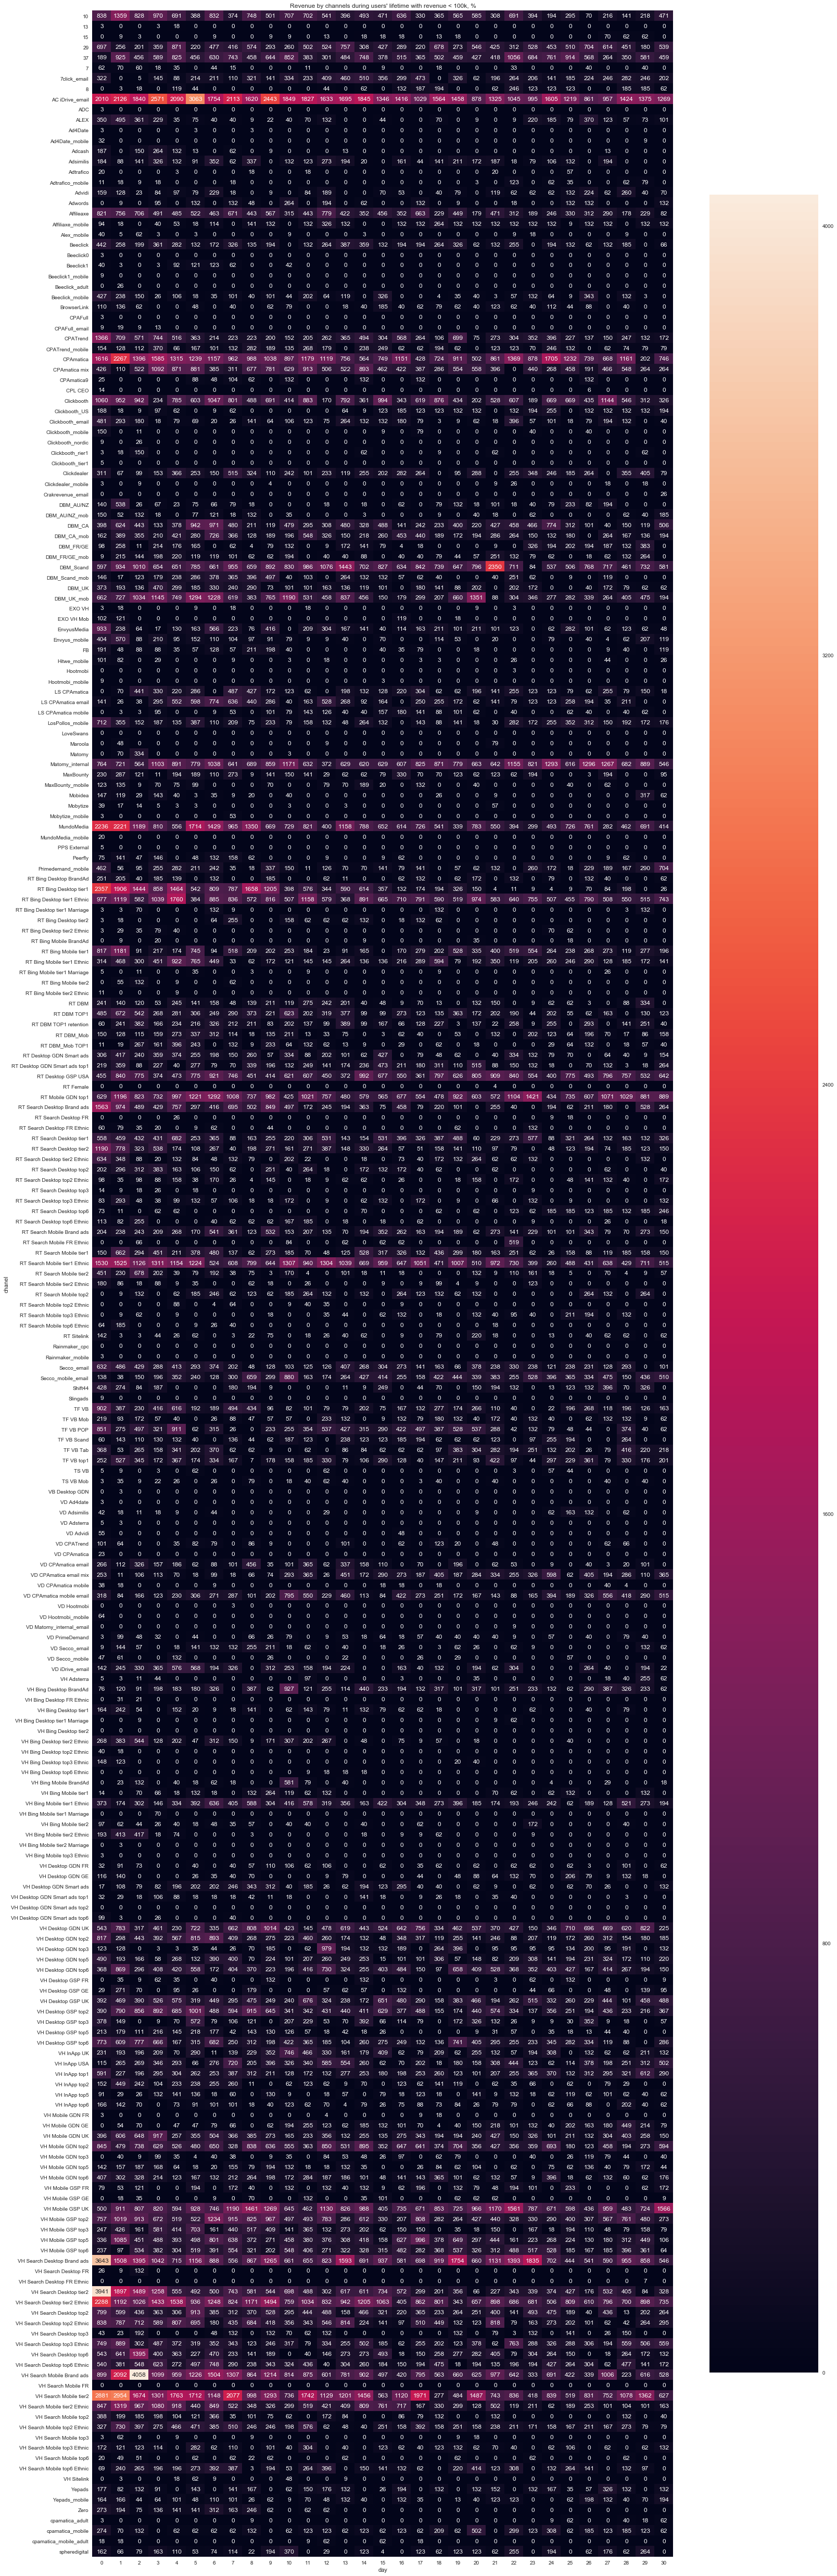

In [128]:
sns.set(style='white')
plt.figure(figsize=(25, 90))
plt.title('Revenue by channels during users\' lifetime with revenue < 100k, %')
ax = sns.heatmap(revenue_lifetimes_slice.T, annot=True, fmt='.0f');
ax = ax.set(xlabel='day', ylabel='chanel')
plt.show()